<a href="https://colab.research.google.com/github/SneyderGF/Brain-Tumor-detection-by-MRI/blob/main/Yes_or_Not_Brain_Tumor_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
Root = "//content/drive/MyDrive/Colab Notebooks/THESIS/brain_tumor_dataset"
os.chdir(Root)

In [ ]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2

In [ ]:
data = '//content/drive/MyDrive/Colab Notebooks/THESIS/brain_tumor_dataset'
No_brain_tumor = '/content/drive/MyDrive/Colab Notebooks/THESIS/brain_tumor_dataset/no'
Yes_brain_tumor = '/content/drive/MyDrive/Colab Notebooks/THESIS/brain_tumor_dataset/yes'

In [ ]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  255    labels:  255


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(255,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/Colab Notebooks/THESIS/...,No
1,/content/drive/MyDrive/Colab Notebooks/THESIS/...,No
2,/content/drive/MyDrive/Colab Notebooks/THESIS/...,No
3,/content/drive/MyDrive/Colab Notebooks/THESIS/...,No
4,/content/drive/MyDrive/Colab Notebooks/THESIS/...,No


In [ ]:
print(df['labels'].value_counts())

Yes    156
No      99
Name: labels, dtype: int64


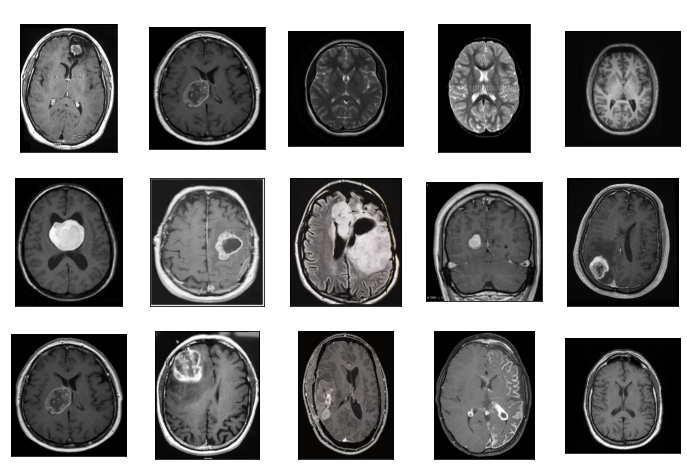

In [ ]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (217, 2)
test set shape: (13, 2)
validation set shape: (25, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:

train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32,
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid,
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels',
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 217 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [ ]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94683136/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100,
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
7/7 [==============================] - 70s 8s/step - loss: 0.7768 - accuracy: 0.5853 - val_loss: 0.7006 - val_accuracy: 0.6000
Epoch 2/100
7/7 [==============================] - 4s 547ms/step - loss: 0.8353 - accuracy: 0.5161 - val_loss: 0.7457 - val_accuracy: 0.5200
Epoch 3/100
7/7 [==============================] - 4s 582ms/step - loss: 0.7271 - accuracy: 0.5899 - val_loss: 0.7136 - val_accuracy: 0.6000
Epoch 4/100
7/7 [==============================] - 4s 602ms/step - loss: 0.7485 - accuracy: 0.5207 - val_loss: 0.7389 - val_accuracy: 0.4800
Epoch 5/100
7/7 [==============================] - 5s 744ms/step - loss: 0.7761 - accuracy: 0.5438 - val_loss: 0.7412 - val_accuracy: 0.4800
Epoch 6/100
7/7 [==============================] - 4s 528ms/step - loss: 0.7733 - accuracy: 0.4700 - val_loss: 0.7145 - val_accuracy: 0.4800
Epoch 7/100
7/7 [==============================] - 5s 790ms/step - loss: 0.7171 - accuracy: 0.5622 - val_loss: 0.6264 - val_accuracy: 0.6800
Epoch 8/100
7/7

In [ ]:
model.save("//content/drive/MyDrive/Colab Notebooks/THESIS/brain_tumor_dataset/Tumor_classifier_model.h5")

In [ ]:
## EVALUATING THE MODEL

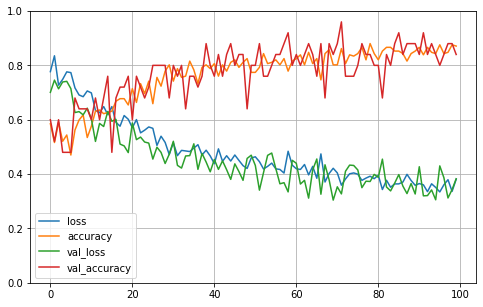

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Tumor detected


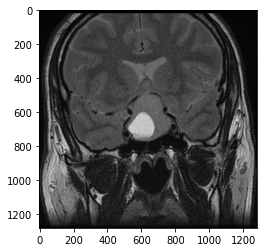

In [ ]:
from PIL import Image
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/THESIS/brain_tumor_dataset/yes/image(15).jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.486:
  plt.imshow(image)
  print("Tumor detected")

else:
  plt.imshow(image)
  print("Tumor No Detected")


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}